# b vs q Classifier

This notebook trains a GNN for binary classifictaion of b-jets vs light-jets. Requires Python 3.9 and  "gnn_env" conda environment on sneezy. Skip to training performance to load training plots. If training is redone, manually update names for outputs (e.g. change outputs like full_bcq_model1.pth to full_bcq_model2.pth to prevent overwriting previous training).

* Data is processed and saved as csv in "process_data.ipynb" to be used for training here

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_add_pool, GraphConv
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import random
import uproot
import time

In [ ]:
# Check if GPU is available
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Read from processed data
combined_df = pd.read_csv("combined_data.csv")

In [ ]:
# Save df for each class before applying cuts
precut_b = combined_df[combined_df['Class'] == 0].reset_index(drop=True)
precut_q = combined_df[combined_df['Class'] == 2].reset_index(drop=True)

In [32]:
print(f'There are {len(precut_b)} b-jet events (signal)')
print(f'There are {len(precut_q)} q-jet events (background)')

There are 1200000 b-jet events (signal)
There are 1200000 q-jet events (background)


In [33]:
# Apply cuts based on 'Class' value
combined_df = combined_df[
    ((combined_df['Class'] == 0) &
     (combined_df['Jet0_MC_Match'] == 1) &
     (combined_df['Jet0_MC_Jet_EfB'] > 0.6) &
     (combined_df['Jet0_PT'] > 20000) &
     (combined_df['Jet0_Eta'].between(2.2, 4.4))) |

    ((combined_df['Class'] == 2) &
     (combined_df['Jet0_MC_Match'] == 1) &
     (combined_df['Jet0_MC_Jet_EfB'] < 0.2) &
     (combined_df['Jet0_MC_Jet_EfD'] < 0.2) &
     (combined_df['Jet0_PT'] > 20000) &
     (combined_df['Jet0_Eta'].between(2.2, 4.4)))
]

combined_df = combined_df.reset_index(drop=True)

In [ ]:
# Define feature columns including jet-level and daughter-level features

# Select any columns including daughters data
daughter_cols = [col for col in combined_df.columns if "_Daughters" in col]

# Select certain SV tagging variables for feautre input
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']

# Use eta, pT and SV tagging variables for jet-level features
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols

# Use daughters vairables and jet variables for features input
feature_cols = daughter_cols + jet_cols

# Prepare features by converting daughter information to lists and duplicating jet-level features
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

# Remove lists and duplicate jet-level features for combined df
combined_df = prepare_features(combined_df, jet_cols, daughter_cols)

In [ ]:
# Separate signal and background
sig_df = combined_df[combined_df['Class'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = combined_df[combined_df['Class'] == 2].sample(frac=1, random_state=42).reset_index(drop=True)

# Assign truth labels
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Filter columns to include only leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB|weights")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB|weights")]]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

In [ ]:
# Verify that there are equal amounts of sig/ bkg selected for training and testing data

print(f"Efficiency of signal truth matching is: {len(sig_df)/len(precut_b):.4f}")
print(f"Efficiency of background truth matching is: {len(bkg_df)/len(precut_q):.4f}")
print('')
print(f"Total events after truth matching: {len(combined_df)}")
print(f"Number of b-jets after truth matching: {len(sig_df)}")

Efficiency of signal truth matching is: 0.3608
Efficiency of background truth matching is: 0.4081

Total events after truth matching: 922681
Number of b-jets after truth matching: 432962


In [ ]:
# Split data into training, validation, and test sets
sig_df = combined_df[combined_df['IsB'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = combined_df[combined_df['IsB'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

# Split 80% for training data and 20% for testing data
half_train_size = int((sum(combined_df.IsB)*0.8)/2)
half_test_size = int((sum(combined_df.IsB)*0.2)/2)

train_df = pd.concat([sig_df.head(half_train_size), bkg_df.head(half_train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of training data is: {len(train_df)}')

test_df = pd.concat([sig_df.tail(half_test_size), bkg_df.tail(half_test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of testing data is: {len(test_df)}')

# Select remaining events for validation data
validation_df = pd.concat([sig_df.iloc[half_train_size:-half_test_size], bkg_df.iloc[half_train_size:-half_test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of validation data is: {len(validation_df)}')

Length of training data is: 346368
Length of testing data is: 86592
Length of validation data is: 489721


In [ ]:
# Verify that there are equal amounts of sig/ bkg selected for training and testing data

print('Ratio of c to b in datasets:')
print(f'    Training data: {sum(train_df.IsB)/len(train_df)}')
print(f'    Testing data: {sum(test_df.IsB)/len(test_df)}')
print(f'    Validation data: {sum(validation_df.IsB)/len(validation_df)}')

Ratio of c to b in datasets:
    Training data: 0.5
    Testing data: 0.5
    Validation data: 0.4420516988244327


Optionally save stats to file for each training

In [39]:
# Open a file in write mode
with open("outputs_50/bq_data_stats2.txt", "w") as file:
    # Print sizes to confirm split
    file.write(f"Training set size: {len(train_df)}\n")
    file.write(f"Validation set size: {len(validation_df)}\n")
    file.write(f"Testing set size: {len(test_df)}\n\n")
    
    # Print class distributions to confirm balance
    file.write(f"Training set class distribution:\n{train_df['IsB'].value_counts()}\n\n")
    file.write(f"Validation set class distribution:\n{validation_df['IsB'].value_counts()}\n\n")
    file.write(f"Testing set class distribution:\n{test_df['IsB'].value_counts()}\n\n")
    
    # Calculate and print the efficiency for each class (b, c, and q)
    file.write(f"Efficiency of c truth matching is: {len(sig_df)/(len(precut_b)):.4f}\n")
    file.write(f"Efficiency of b truth matching is: {len(bkg_df)/(len(precut_q)):.4f}\n")
    
    # Print total events after truth matching and the number of events for each class
    file.write(f"Total events after truth matching: {len(combined_df)}\n")
    file.write(f"Number of c-jets after truth matching: {len(sig_df)}\n")
    file.write(f"Number of b-jets after truth matching: {len(bkg_df)}\n")

print("Output written to 'outputs_50/bq_data_stats2.txt'")

Output written to 'outputs_50/bq_data_stats2.txt'


# Create Graphs
Jet-level features are duplicated to match number of daughters per event (since daughter features are stores as lists for each daughter). Graphs are constructed with one graph for each leading jet event. Each node within the graph corresponds to a daughter particle within that jet (different numebr of nodes per each graph). Each node has (already duplicated) jet-level features and daughter-level features. All nodes are connected to each other through edges wihtin the graphs.

In [40]:
# Create graphs for training and testing
def create_graphs(df, feature_cols):

    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for idx, features in enumerate(features_list):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()
        edge_weight = torch.tensor([df['weights'].iloc[idx]] * edge_index.size(1), dtype=torch.float) 

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Create graphs for training and testing
train_data = create_graphs(train_df, feature_cols)
test_data = create_graphs(test_df, feature_cols)

# Load data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Classifier

In [41]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = GraphConv(len(feature_cols), hidden_channels)
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index, batch, edge_weight):        
        x = self.conv1(x, edge_index, edge_weight)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index, edge_weight)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)
    
model = GNN()
model = model.to(device)

In [ ]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # reduce lr by 0.5 every 5 epochs


# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch, data.edge_weight)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch, data.edge_weight)
            loss = criterion(out, data.y.float())
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
            total_loss += loss.item() * data.num_graphs

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / total_samples
    return avg_loss, acc

# Training parameters
num_epochs = 300

# Initialize lists for storing loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):

    train_loss = train()
    train_loss_values.append(train_loss)

    train_acc = test(train_loader)[1]
    train_acc_values.append(train_acc)

    test_loss, test_acc = test(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    scheduler.step(test_loss)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Save the model and results every 50 epochs
    if (epoch + 1) % 50 == 0:
        # Overwrite the existing model file
        torch.save(model.state_dict(), 'outputs_50/bq_model2.pth')
        print('Model saved as outputs_50/bq_model2.pth.')

        # Save the loss and accuracy values to a CSV file, overwriting the existing file
        results_df = pd.DataFrame({
            'Epoch': list(range(1, epoch + 2)),
            'Train Loss': train_loss_values,
            'Test Loss': test_loss_values,
            'Train Accuracy': train_acc_values,
            'Test Accuracy': test_acc_values
        })
        results_df.to_csv('outputs_50/bq_training2.csv', index=False)
        print('Training results saved as outputs_50/bq_training2.csv.')

torch.save(model.state_dict(), 'outputs_50/bq_model2.pth')
print('Model saved as outputs_50/bq_model2.pth. Training complete.')

results_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs+1)),
    'Train Loss': train_loss_values,
    'Test Loss': test_loss_values,
    'Train Accuracy': train_acc_values,
    'Test Accuracy': test_acc_values
})

# Save the loss and accuracy values to a CSV file
results_df.to_csv('outputs_50/bq_training2.csv', index=False)
print('Training results saved as outputs_50/bq_training2.csv. Training complete.')

Epoch: 001, Train Loss: 0.4722, Test Loss: 0.4342, Train Acc: 0.7923, Test Acc: 0.7914
Epoch: 002, Train Loss: 0.4366, Test Loss: 0.4295, Train Acc: 0.7933, Test Acc: 0.7927
Epoch: 003, Train Loss: 0.4328, Test Loss: 0.4270, Train Acc: 0.7932, Test Acc: 0.7927
Epoch: 004, Train Loss: 0.4296, Test Loss: 0.4240, Train Acc: 0.7931, Test Acc: 0.7925
Epoch: 005, Train Loss: 0.4273, Test Loss: 0.4214, Train Acc: 0.7935, Test Acc: 0.7929
Epoch: 006, Train Loss: 0.4262, Test Loss: 0.4244, Train Acc: 0.7933, Test Acc: 0.7933
Epoch: 007, Train Loss: 0.4248, Test Loss: 0.4213, Train Acc: 0.7933, Test Acc: 0.7933
Epoch: 008, Train Loss: 0.4242, Test Loss: 0.4197, Train Acc: 0.7938, Test Acc: 0.7935
Epoch: 009, Train Loss: 0.4235, Test Loss: 0.4189, Train Acc: 0.7935, Test Acc: 0.7935
Epoch: 010, Train Loss: 0.4228, Test Loss: 0.4205, Train Acc: 0.7939, Test Acc: 0.7937
Epoch: 011, Train Loss: 0.4222, Test Loss: 0.4206, Train Acc: 0.7934, Test Acc: 0.7926
Epoch: 012, Train Loss: 0.4216, Test Loss: 

# Visualize training performance

In [42]:
# Reload training data to produce plots
training = pd.read_csv('outputs_50/bq_training2.csv')
train_loss_values = training['Train Loss'].to_list()
test_loss_values = training['Test Loss'].to_list()
train_acc_values = training['Train Accuracy'].to_list()
test_acc_values = training['Test Accuracy'].to_list()

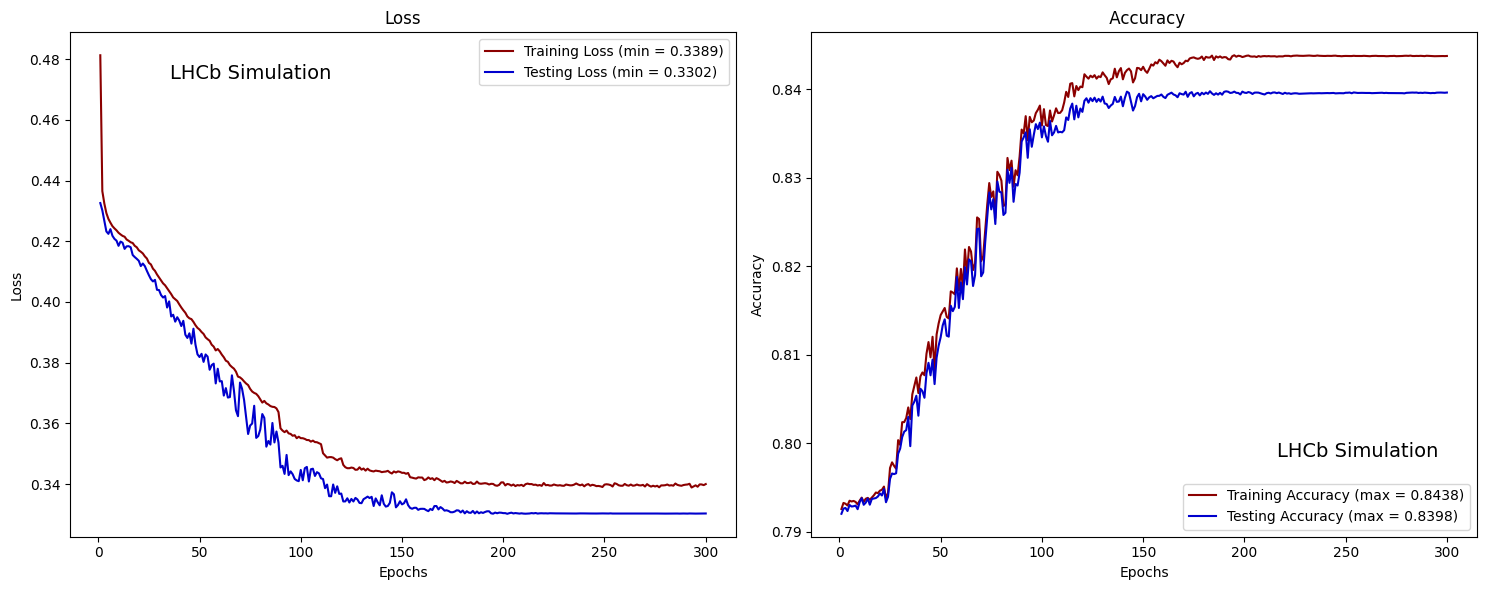

In [ ]:
# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, len(train_loss_values) + 1)

    mean_train_loss = np.mean(train_loss_values)
    mean_test_loss = np.mean(test_loss_values)
    mean_train_acc = np.mean(train_acc_values)
    mean_test_acc = np.mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    #fig.suptitle('Training Results', fontsize=16)  # optional title

    # Plot Loss
    ax1.plot(epochs, train_loss_values, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))

    ax1.text(0.15, 0.90, "LHCb Simulation", transform=ax1.transAxes, fontsize=14, verticalalignment='bottom')

    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4})"))

    ax2.text(0.7, 0.15, "LHCb Simulation", transform=ax2.transAxes, fontsize=14, verticalalignment='bottom')

    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.savefig('outputs_50/bq_loss_acc2.png', bbox_inches='tight')
    plt.show()
    
plot_training_results()

Make predictions using trained GNN - calculate tpr, fpr, thresholds (cutoffs for certain probabiltities), and auc.

In [ ]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.load_state_dict(torch.load('outputs_50/bq_model2.pth')) # must run the cell containing model arhictecture to now load previous weights
model = model.to('cpu')
model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch, data.edge_weight)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# Save each array separately
np.save('outputs_50/bq_fpr2.npy', fpr)
np.save('outputs_50/bq_tpr2.npy', tpr)
np.save('outputs_50/bq_thresholds2.npy', thresholds)
np.save('outputs_50/bq_auc2.npy', auc)

Plot performance of other classifiers together

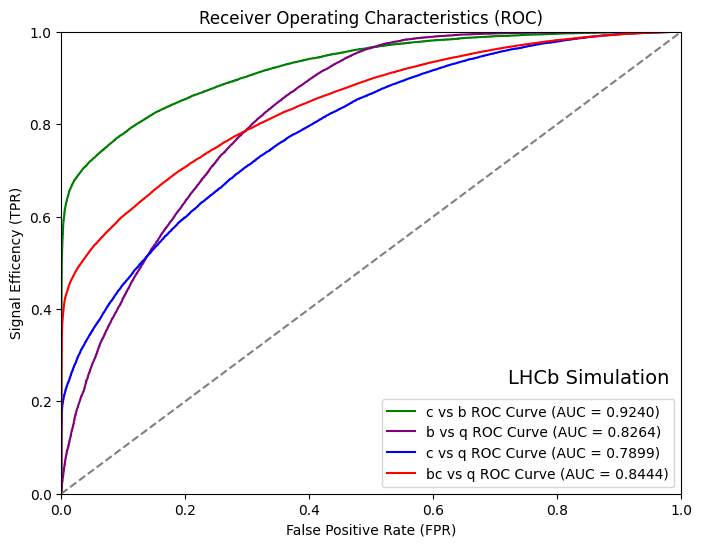

In [ ]:
# Load ROC data
fpr1 = np.load('outputs_50/bq_fpr2.npy', allow_pickle=True)
tpr1 = np.load('outputs_50/bq_tpr2.npy', allow_pickle=True)
thresholds1 = np.load('outputs_50/bq_thresholds2.npy', allow_pickle=True)
auc1 = np.load('outputs_50/bq_auc2.npy', allow_pickle=True)

fpr2 = np.load('outputs_50/cb_fpr2.npy', allow_pickle=True)
tpr2 = np.load('outputs_50/cb_tpr2.npy', allow_pickle=True)
thresholds2 = np.load('outputs_50/cb_thresholds2.npy', allow_pickle=True)
auc2 = np.load('outputs_50/cb_auc2.npy', allow_pickle=True)

fpr3 = np.load('outputs_50/cq50_fpr1.npy', allow_pickle=True)
tpr3 = np.load('outputs_50/cq50_tpr1.npy', allow_pickle=True)
thresholds3 = np.load('outputs_50/cq50_thresholds1.npy', allow_pickle=True)
auc3 = np.load('outputs_50/cq50_auc1.npy', allow_pickle=True)

fpr4 = np.load('outputs_50/bcq_fpr1.npy', allow_pickle=True)
tpr4 = np.load('outputs_50/bcq_tpr1.npy', allow_pickle=True)
thresholds4 = np.load('outputs_50/bcq_thresholds1.npy', allow_pickle=True)
auc4 = np.load('outputs_50/bcq_auc1.npy', allow_pickle=True)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'c vs b ROC Curve (AUC = {auc1:.4f})', color='green')
plt.plot(fpr2, tpr2, label=f'b vs q ROC Curve (AUC = {auc2:.4f})', color='purple')
plt.plot(fpr3, tpr3, label=f'c vs q ROC Curve (AUC = {auc3:.4f})', color='blue')
plt.plot(fpr4, tpr4, label=f'bc vs q ROC Curve (AUC = {auc4:.4f})', color='red')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Labels and legend
plt.text(0.85, 0.25, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('Signal Efficency (TPR)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.savefig('outputs_50/bq_cq_rocs2.png', bbox_inches='tight')
plt.show()

In [50]:
# Get FPRs for TPRs
desired_tpr = [0.85, 0.80, 0.75, 0.70, 0.65, 0.60]

print("Efficiency | FPR ")
for val in desired_tpr:
    # Find the index of the closest TPR to the desired TPR value
    closest_index = np.argmin(np.abs(tpr - val))

    # Get the chosen threshold and corresponding FPR, where the threshold is the probability cutoff
    chosen_threshold = thresholds[closest_index]
    given_fpr = fpr[closest_index]
    print(f"{val}: {given_fpr:.4f}")

Efficiency | FPR 
0.85: 0.1922
0.8: 0.1212
0.75: 0.0723
0.7: 0.0332
0.65: 0.0118
0.6: 0.0046


In [ ]:
# Choose a tpr, find closest threshold and given probability
chosen_tpr = 0.75
closest_index = np.argmin(np.abs(tpr - chosen_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {chosen_tpr}: Pb {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.75: Pb 0.5524: FPR 0.0723


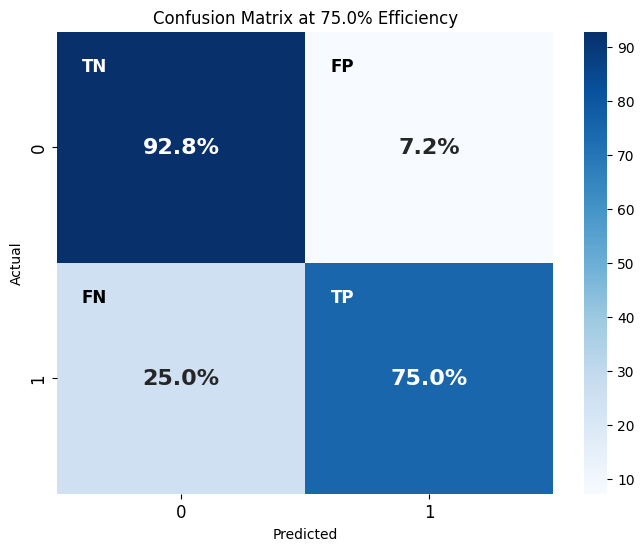

In [ ]:
# Choose efficency: chosen_threshold is given p cutoff 
y_pred_binary = (y_scores >= chosen_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

cm_percentage = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

# Uses percent tpr/ fpr for labels
annot_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm_percentage[i, j]
        annot_labels[i, j] = f'{percentage:.1f}%'

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion Matrix at {chosen_tpr*100}% Efficiency")

ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
plt.savefig('outputs_50/bq_cmp2.png', bbox_inches='tight')
plt.show()

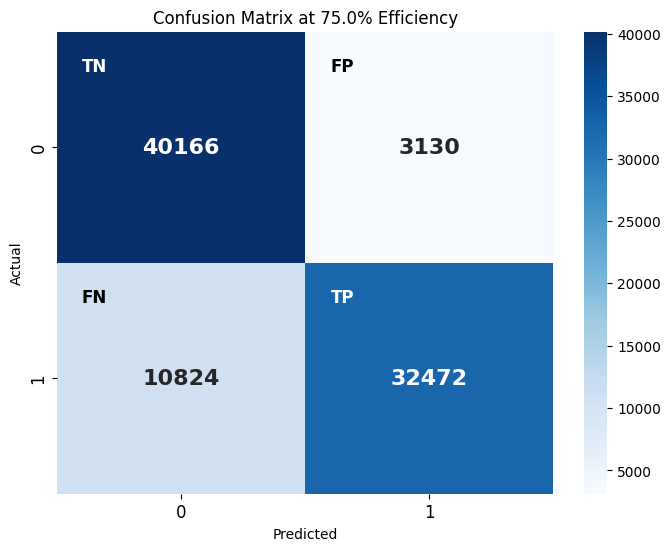

In [ ]:
# Choose efficency: chosen_threshold is given p cutoff 
y_pred_binary = (y_scores >= chosen_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)
df_cm = pd.DataFrame(cm)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Uses number of events with tp/ fp, etc
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion Matrix at {chosen_tpr*100}% Efficiency")

# Add TP, FP, FN, TN labels
ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
plt.savefig('outputs_50/bq_cm2.png', bbox_inches='tight')
plt.show()

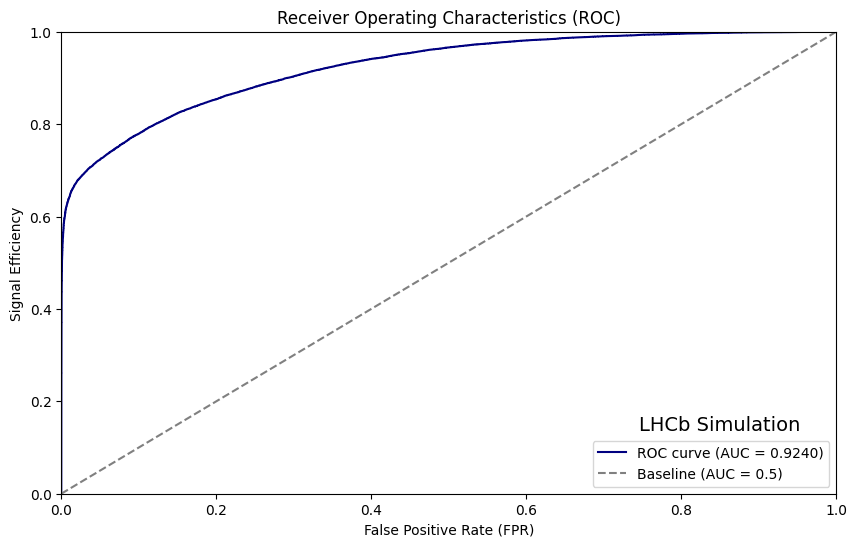

In [ ]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.style.use('default')
plt.ylabel('Signal Efficiency')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.text(0.85, 0.15, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.legend(loc='lower right')
plt.savefig('outputs_50/bq_roc2.png', bbox_inches='tight')
plt.show()

# Plot feature importance

Feature ablation: perturb one feature at a time and compare performance

                                Feature  Importance
0                      Jet0_Daughters_E    1.038598
1                     Jet0_Daughters_pT    0.725996
2                     Jet0_Daughters_ID    0.059713
3                     Jet0_Daughters_pX    0.378024
4                     Jet0_Daughters_pY    0.537589
5                     Jet0_Daughters_pZ    1.366060
6                    Jet0_Daughters_Eta    0.015342
7                    Jet0_Daughters_Phi    0.003473
8                      Jet0_Daughters_Q    0.000551
9                     Jet0_Daughters_IP    0.145841
10                Jet0_Daughters_IPCHI2    1.620610
11                 Jet0_Daughters_IPraw    0.041417
12                   Jet0_Daughters_NNe    0.510969
13                   Jet0_Daughters_NNk    0.248634
14                   Jet0_Daughters_NNp    0.544873
15                  Jet0_Daughters_NNpi    0.547010
16                  Jet0_Daughters_NNmu    1.113793
17                  Jet0_Daughters_Chi2    0.336792
18          

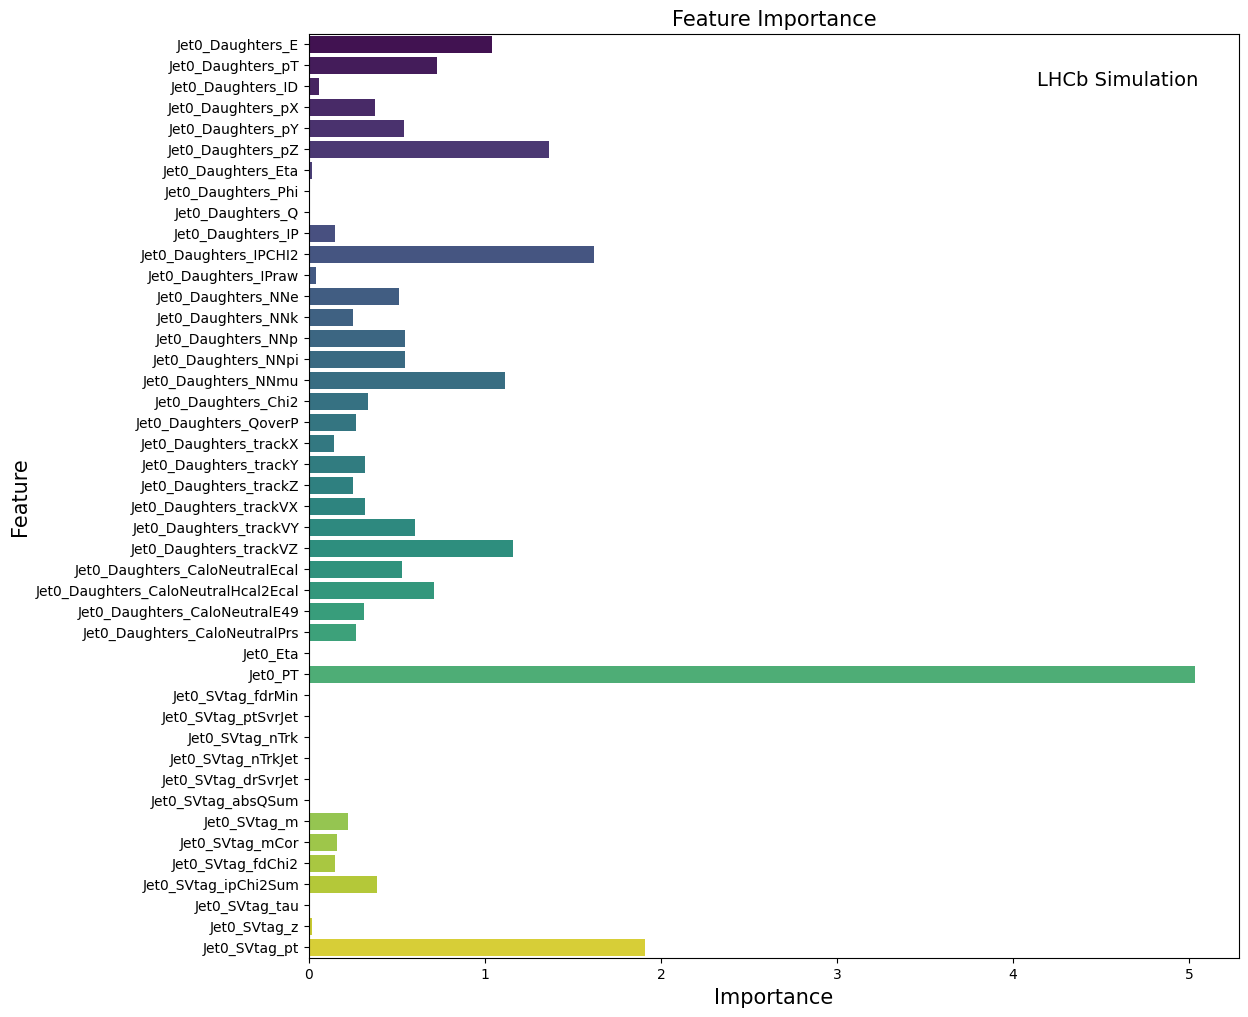

In [ ]:
# Prepare model
model.eval()
data = next(iter(test_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))  # take edges from edge index and add to graph
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1)) # zero array with size of features

for feature_idx in range(x.size(1)):
    x_perturbed = x.clone() # copy of x (node feature matrix)
    x_perturbed[:, feature_idx] = 0 # set feature to 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch, None)
        perturbed_pred = model(x_perturbed, edge_index, batch, None)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred))  # difference in predictions
    feature_importances[feature_idx] = importance

importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})
print(importance_df)

plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance', fontsize=15)
plt.text(0.87, 0.95, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.savefig('outputs_50/bq_features2.png', bbox_inches='tight')
plt.show()

Same polt, just sorted:

                                Feature  Importance
30                              Jet0_PT    5.030720
43                        Jet0_SVtag_pt    1.909004
10                Jet0_Daughters_IPCHI2    1.620610
5                     Jet0_Daughters_pZ    1.366060
24               Jet0_Daughters_trackVZ    1.160426
16                  Jet0_Daughters_NNmu    1.113793
0                      Jet0_Daughters_E    1.038598
1                     Jet0_Daughters_pT    0.725996
26  Jet0_Daughters_CaloNeutralHcal2Ecal    0.710647
23               Jet0_Daughters_trackVY    0.601507
15                  Jet0_Daughters_NNpi    0.547010
14                   Jet0_Daughters_NNp    0.544873
4                     Jet0_Daughters_pY    0.537589
25       Jet0_Daughters_CaloNeutralEcal    0.526994
12                   Jet0_Daughters_NNe    0.510969
40                 Jet0_SVtag_ipChi2Sum    0.384352
3                     Jet0_Daughters_pX    0.378024
17                  Jet0_Daughters_Chi2    0.336792
22          

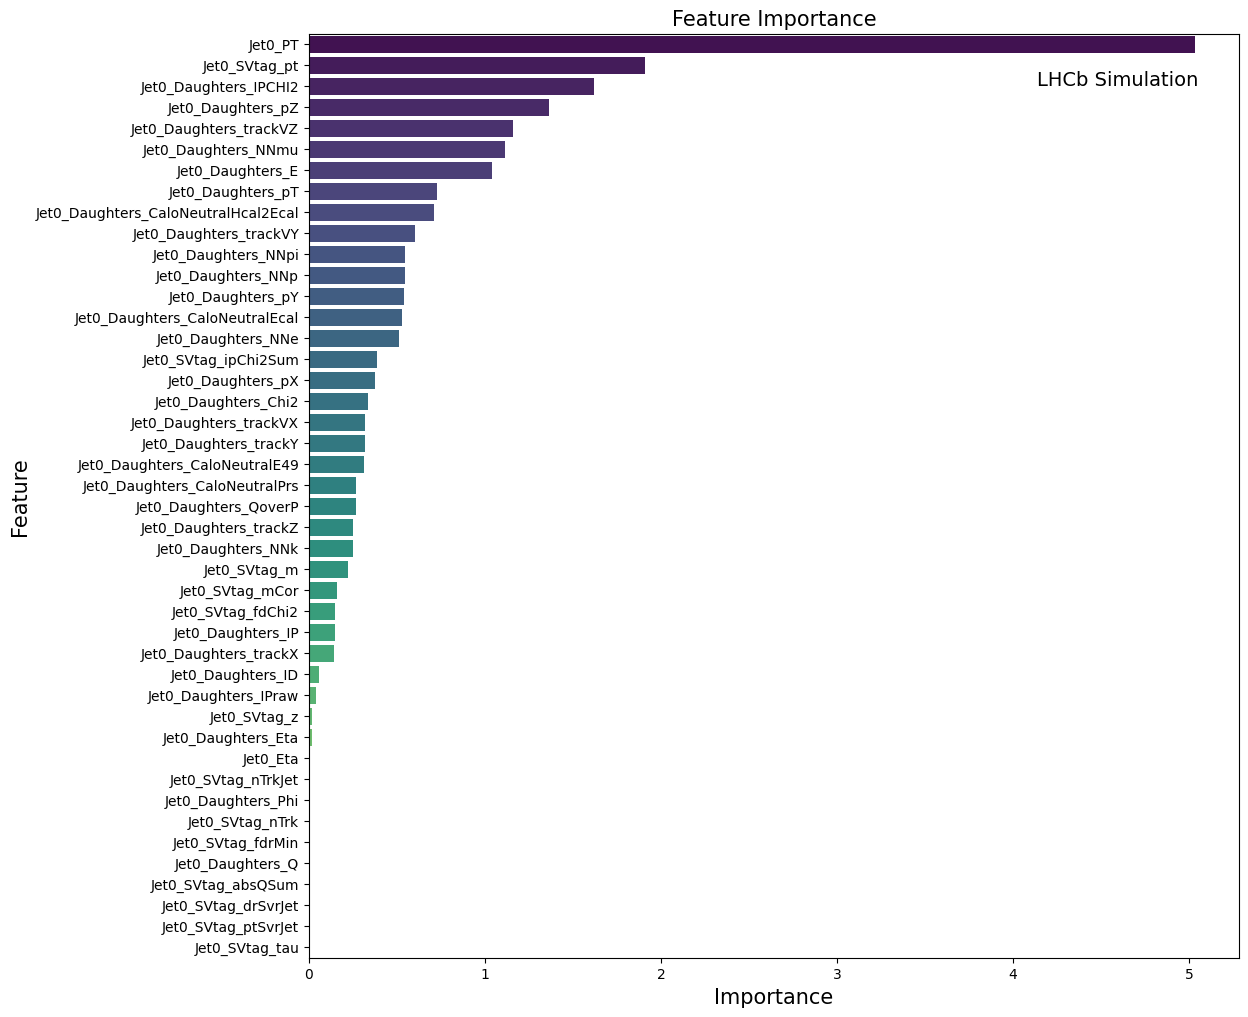

In [56]:
# Prepare model
model.eval()
data = next(iter(test_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1))

for feature_idx in range(x.size(1)):
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch, None)
        perturbed_pred = model(x_perturbed, edge_index, batch, None)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred))
    feature_importances[feature_idx] = importance

importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance', fontsize=15)
plt.text(0.87, 0.95, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.savefig('outputs_50/bq_features2_decsending.png', bbox_inches='tight')
plt.show()

In [ ]:
# Print features and importance with values > 0.25 (& helpful for importing to latex table)
for index, row in importance_df.iterrows():
    feature = row['Feature'] 
    importance = row['Importance']
    if importance > 0.25:
        print(f'{feature} & {importance:4f}')

Jet0_PT & 5.030720
Jet0_SVtag_pt & 1.909004
Jet0_Daughters_IPCHI2 & 1.620610
Jet0_Daughters_pZ & 1.366060
Jet0_Daughters_trackVZ & 1.160426
Jet0_Daughters_NNmu & 1.113793
Jet0_Daughters_E & 1.038598
Jet0_Daughters_pT & 0.725996
Jet0_Daughters_CaloNeutralHcal2Ecal & 0.710647
Jet0_Daughters_trackVY & 0.601507
Jet0_Daughters_NNpi & 0.547010
Jet0_Daughters_NNp & 0.544873
Jet0_Daughters_pY & 0.537589
Jet0_Daughters_CaloNeutralEcal & 0.526994
Jet0_Daughters_NNe & 0.510969
Jet0_SVtag_ipChi2Sum & 0.384352
Jet0_Daughters_pX & 0.378024
Jet0_Daughters_Chi2 & 0.336792
Jet0_Daughters_trackVX & 0.317194
Jet0_Daughters_trackY & 0.317135
Jet0_Daughters_CaloNeutralE49 & 0.311731
Jet0_Daughters_CaloNeutralPrs & 0.269899
Jet0_Daughters_QoverP & 0.265553


# Model Probability Output
Choose a random event from validation df, process into graph, and use GNN to make prediction

In [58]:
df = validation_df
chosen_threshold = 0.5

def make_predictions():
    # Select a random integer for sampling
    random_integer = np.random.randint(0, len(df))
    sample_jet = df.iloc[random_integer:random_integer+1].copy()

    # Filter columns related to Jet0
    sample_jet = sample_jet.filter(like='Jet0')

    # Define feature columns
    daughter_cols = [col for col in sample_jet.columns if "_Daughters" in col]
    svtag_cols = ['Jet0_SVtag_fdrMin',
    'Jet0_SVtag_ptSvrJet',
    'Jet0_SVtag_nTrk',
    'Jet0_SVtag_nTrkJet',
    'Jet0_SVtag_drSvrJet',
    'Jet0_SVtag_absQSum',
    'Jet0_SVtag_m',
    'Jet0_SVtag_mCor',
    'Jet0_SVtag_fdChi2',
    'Jet0_SVtag_ipChi2Sum',
    'Jet0_SVtag_tau',
    'Jet0_SVtag_z',
    'Jet0_SVtag_pt']
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    for col in jet_cols:
        sample_jet[col] = sample_jet.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)
    for col in daughter_cols:
        sample_jet[col] = sample_jet[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Obtain features of each node within the graph
    features_list = []
    for _, row in sample_jet.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    # Create graph representation with data objects
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    for data in data_objects:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch, data.edge_weight)
            probability = torch.sigmoid(output)
            prediction = (probability > chosen_threshold).int()

    print(f'Probability: {probability.item()}')
    if prediction.item() == 1:  
        print(f'Prediction: c-jet')
    if prediction.item() == 0:  
        print(f'Prediction: q-jet')
    return probability.item()

i = 0

for i in range(100):
    make_predictions()

Probability: 0.9635334610939026
Prediction: c-jet
Probability: 0.9754362106323242
Prediction: c-jet
Probability: 0.0020790782291442156
Prediction: q-jet
Probability: 0.34570273756980896
Prediction: q-jet
Probability: 0.9902015328407288
Prediction: c-jet
Probability: 0.543583333492279
Prediction: c-jet
Probability: 0.321681410074234
Prediction: q-jet
Probability: 0.1278589814901352
Prediction: q-jet
Probability: 0.538612425327301
Prediction: c-jet
Probability: 0.3522182106971741
Prediction: q-jet
Probability: 0.3418325185775757
Prediction: q-jet
Probability: 0.32033589482307434
Prediction: q-jet
Probability: 0.22650130093097687
Prediction: q-jet
Probability: 0.9981247782707214
Prediction: c-jet
Probability: 0.9984647035598755
Prediction: c-jet
Probability: 0.17744359374046326
Prediction: q-jet
Probability: 0.9984242916107178
Prediction: c-jet
Probability: 0.2947293817996979
Prediction: q-jet
Probability: 0.9914929270744324
Prediction: c-jet
Probability: 0.032338712364435196
Prediction: 

# Create Efficiency Plot

In [59]:
model.load_state_dict(torch.load('outputs_50/bq_model2.pth'))
model = model.to('cpu')

This creates probability distribution by separating the sig/ bkg events and feeding them into the classifier.

In [60]:
# Separate b and q data from testing dataset (preprocessed)
b = test_df[test_df.IsB == 1]
q = test_df[test_df.IsB == 0]

b_data = create_graphs(b, feature_cols)
q_data = create_graphs(q, feature_cols)

b_prob = []
q_prob = []

def get_probabilities(data_list):
    prob_list = []
    model.eval()
    with torch.no_grad():
        for data in data_list:
            out = model(data.x, data.edge_index, data.batch, data.edge_weight)
            prob = torch.sigmoid(out).numpy().flatten()
            prob_list.append(prob)
    return np.concatenate(prob_list)

# Compute probabilities for b and q data
b_prob = get_probabilities(b_data)
q_prob = get_probabilities(q_data)

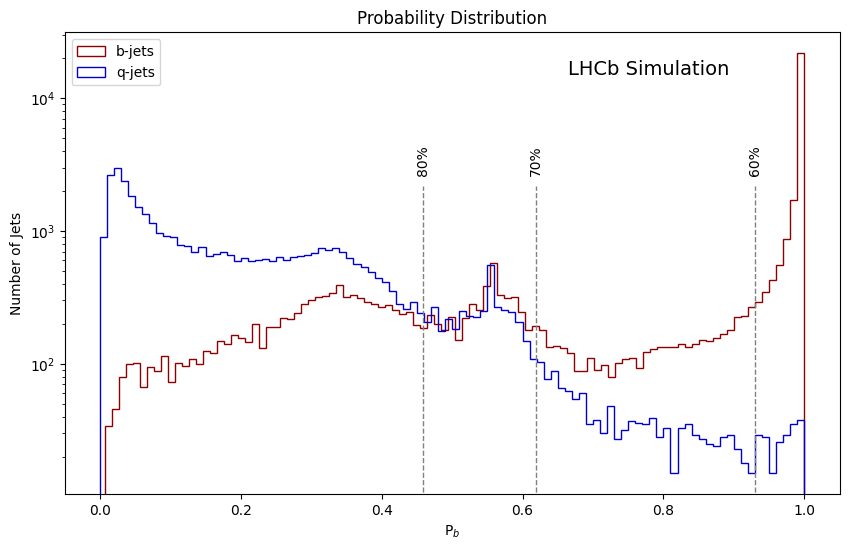

In [61]:
def plot_probability_distribution(b_prob, q_prob, target_efficiencies):

    # Sort b-jet probabilities in descending order for cutoff calculations
    sorted_b_prob = np.sort(b_prob)[::-1]
    
    # Calculate cutoffs for each efficiency level
    cutoffs = {}
    for efficiency in target_efficiencies:
        cutoff_index = int(len(sorted_b_prob) * efficiency)
        cutoffs[efficiency] = sorted_b_prob[cutoff_index - 1] if cutoff_index > 0 else sorted_b_prob[0]
    
    # Plot histograms for b-jet and q-jet probabilities
    plt.figure(figsize=(10, 6))
    b_values, b_bins, _ = plt.hist(b_prob, bins=100, label='b-jets', color='darkred', histtype='step')
    q_values, q_bins, _ = plt.hist(q_prob, bins=100, label='q-jets', color='mediumblue', histtype='step')

    max_y = max(max(b_values), max(q_values))
    
    # Mark cutoffs for selected efficiencies
    for i, (efficiency, cutoff) in enumerate(cutoffs.items()):
        plt.vlines(x=cutoff, ymin=0, ymax=max_y * 0.1, color='grey', linestyle='--', linewidth=1)
        plt.text(cutoff, max_y*0.12, f'{int(efficiency * 100)}%', ha='center', va='bottom', rotation=90)

    plt.xlabel("P$_b$")
    plt.ylabel("Number of Jets")
    plt.text(0.65, 0.9, "LHCb Simulation", transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom')
    plt.title("Probability Distribution")
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig('outputs_50/bq_prob2.png', bbox_inches='tight')
    plt.show()

target_efficiencies = [0.6, 0.7, 0.8]
plot_probability_distribution(b_prob, q_prob, target_efficiencies)

In [ ]:
# Select WP and find corresponding prob cutoff
chosen_tpr = 0.75
closest_index = np.argmin(np.abs(tpr - chosen_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {chosen_tpr}: Pb {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.75: Pb 0.5524: FPR 0.0723


# Plot Efficiencies vs pT

In [ ]:
# Select signal data from test_df
b = test_df[test_df.IsB == 1]
b.loc[:, 'Jet0_PT'] = b['Jet0_PT'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Create new dfs for different pT ranges
pt23_df = b[(b['Jet0_PT'].between(20000, 30000))].reset_index(drop=True)
pt34_df = b[(b['Jet0_PT'].between(30000, 40000))].reset_index(drop=True)
pt45_df = b[(b['Jet0_PT'].between(40000, 50000))].reset_index(drop=True)
pt50_df = b[(b['Jet0_PT'].between(50000, 100000))].reset_index(drop=True)

In [ ]:
# Feed data into GNN and count number of correct predictions
def make_predictions(df):
    daughter_cols = [col for col in df.columns if "_Daughters" in col]
    svtag_cols = [
        'Jet0_SVtag_fdrMin',
        'Jet0_SVtag_ptSvrJet',
        'Jet0_SVtag_nTrk',
        'Jet0_SVtag_nTrkJet',
        'Jet0_SVtag_drSvrJet',
        'Jet0_SVtag_absQSum',
        'Jet0_SVtag_m',
        'Jet0_SVtag_mCor',
        'Jet0_SVtag_fdChi2',
        'Jet0_SVtag_ipChi2Sum',
        'Jet0_SVtag_tau',
        'Jet0_SVtag_z',
        'Jet0_SVtag_pt'
    ]
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Get features of each node within the graph
    features_list = []
    for _, row in df.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    num_b = 0
    for data in data_objects:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch, data.edge_weight)
            probability = torch.sigmoid(output)
            prediction = (probability > chosen_threshold).int()

            # Count how many times b-jets are predicted from sample of only b-jets
            if prediction.item() == 1:  
                num_b += 1

    return num_b

In [ ]:
# Make predictions for each pT range
num_c23 = make_predictions(pt23_df)
num_c34 = make_predictions(pt34_df)
num_c45 = make_predictions(pt45_df)
num_c50 = make_predictions(pt50_df)

# Calculate efficiencies
efficiency23 = num_c23 / len(pt23_df)
efficiency34 = num_c34 / len(pt34_df)
efficiency45 = num_c45 / len(pt45_df)
efficiency50 = num_c50 / len(pt50_df)

print(f'Efficiency for pT 20-30 GeV: {efficiency23:.4f}')
print(f'Efficiency for pT 30-40 GeV: {efficiency34:.4f}')
print(f'Efficiency for pT 40-50 GeV: {efficiency45:.4f}')
print(f'Efficiency for pT 50-100 GeV: {efficiency50:.4f}')

Efficiency for pT 20-30 GeV: 0.7343
Efficiency for pT 30-40 GeV: 0.7544
Efficiency for pT 40-50 GeV: 0.7703
Efficiency for pT 50-100 GeV: 0.7569


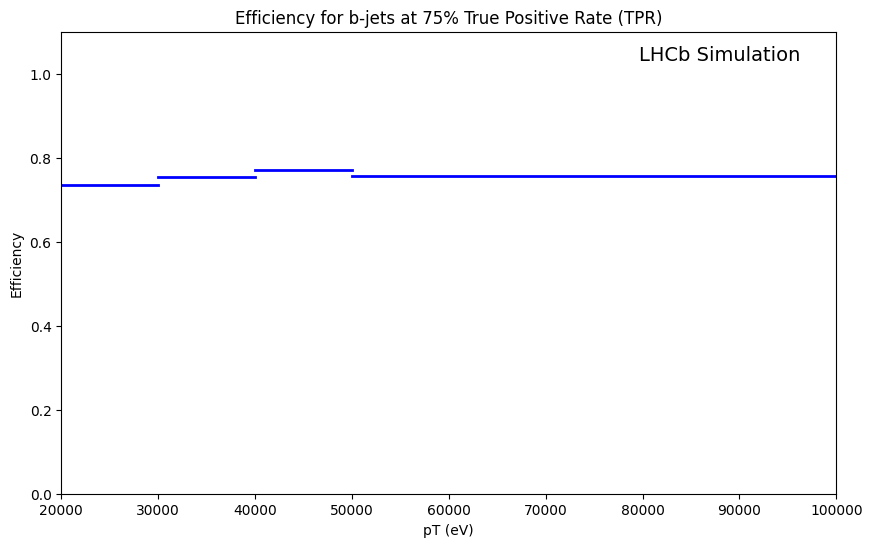

In [ ]:
# Plot efficiencies for each pT bin
def plot_efficiency_histogram(efficiencies, pt_bins):
    plt.figure(figsize=(10, 6))

    # Calculate bin centers and widths
    bin_centers = (pt_bins[:-1] + pt_bins[1:]) / 2
    bar_width = np.diff(pt_bins)  # Width of the bins

    # Create the histogram by plotting only the tops of the bins
    for i in range(len(efficiencies)):
        plt.plot([pt_bins[i], pt_bins[i+1]], [efficiencies[i], efficiencies[i]], color='blue', linewidth=2)
    plt.xticks(np.arange(20000, 101000, 10000))
    plt.xlabel('pT (eV)')
    plt.ylabel('Efficiency')
    plt.text(0.85, 0.95, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
    plt.title('Efficiency for b-jets at 75% True Positive Rate (TPR)')
    plt.ylim(0, 1.1)
    plt.xlim(20000, 100000)
    plt.savefig('outputs_50/bq_efficiency21.png', bbox_inches='tight')
    plt.show()

# Define bin ranges
pt_bins = np.array([20000, 30000, 40000, 50000, 100000])
efficiencies = [efficiency23, efficiency34, efficiency45, efficiency50]

plot_efficiency_histogram(efficiencies, pt_bins)

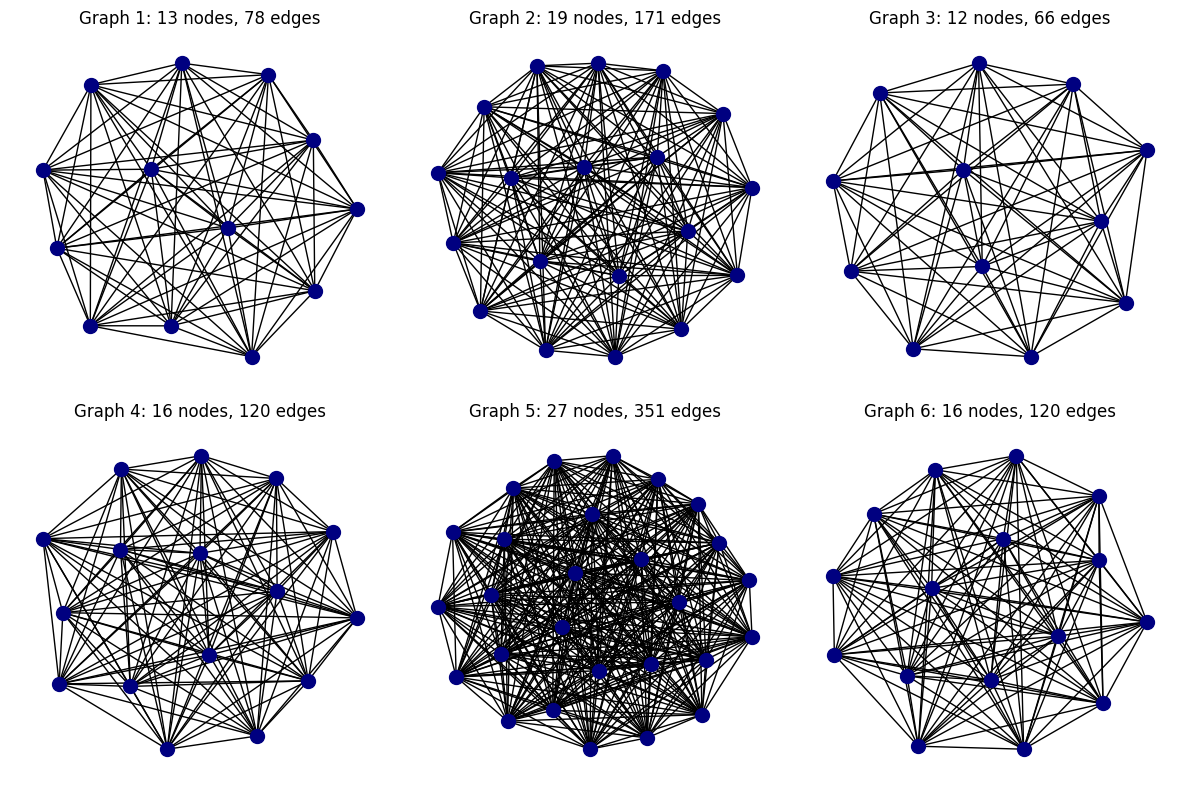

In [67]:
# Visualize some graphs
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, data in enumerate(train_loader.dataset[:6]):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    nx.draw(G, ax=axes[i], node_color='navy', node_size=100)
    
    axes[i].set_title(f"Graph {i+1}: {data.num_nodes} nodes, {data.edge_index.size(1)} edges")

plt.tight_layout()
plt.savefig('outputs_50/bq_graphs2.png', bbox_inches='tight')
plt.show()

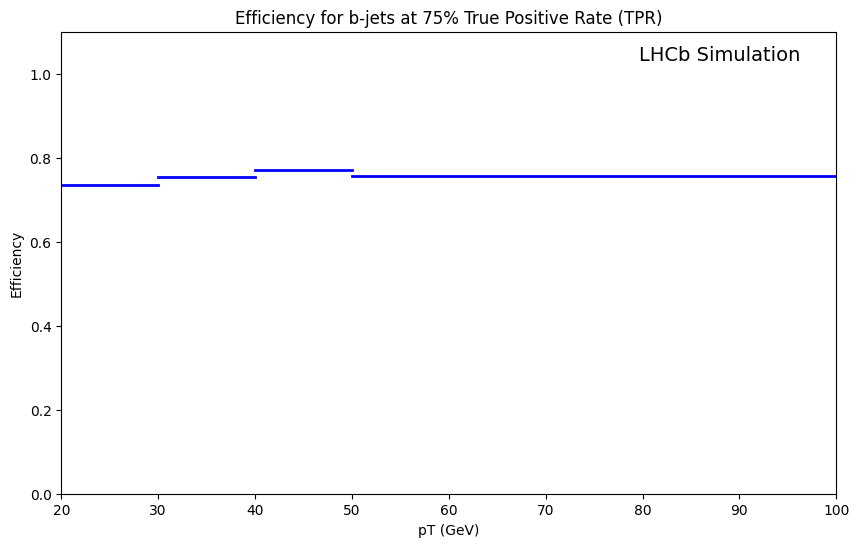

In [68]:
def plot_efficiency_histogram(efficiencies, pt_bins):
    plt.figure(figsize=(10, 6))

    # Calculate bin centers and widths
    bin_centers = (pt_bins[:-1] + pt_bins[1:]) / 2
    bar_width = np.diff(pt_bins)  # Width of the bins

    # Create the histogram by plotting only the tops of the bins
    for i in range(len(efficiencies)):
        plt.plot([pt_bins[i], pt_bins[i+1]], [efficiencies[i], efficiencies[i]], color='blue', linewidth=2)

    # Update x-axis tick labels divided by 1000
    plt.xticks(np.arange(20000, 101000, 10000), labels=(np.arange(20, 101, 10)))

    plt.xlabel('pT (GeV)')
    plt.ylabel('Efficiency')
    plt.text(0.85, 0.95, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
    plt.title('Efficiency for b-jets at 75% True Positive Rate (TPR)')
    plt.ylim(0, 1.1)
    plt.xlim(20000, 100000)
    plt.savefig('outputs_50/bq_efficiency22.png', bbox_inches='tight')
    plt.show()

# Custom bin ranges (with unequal bins for the upper range)
pt_bins = np.array([20000, 30000, 40000, 50000, 100000])
efficiencies = [efficiency23, efficiency34, efficiency45, efficiency50]

plot_efficiency_histogram(efficiencies, pt_bins)
